In [1]:
import os
from env import host, user, password

import numpy as np
import pandas as pd
from scipy import stats
from sklearn.model_selection import train_test_split

import sklearn.preprocessing
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression, RFE

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

key|old_key|description
aircon|airconditioningtypeid|Type of cooling system present in the home (if any)architectural_style
architecturalstyletypeid|architecturalstyletypeid|Architectural style of the home (i.e. ranch, colonial, split-level, etc…)
area_base|finishedsquarefeet6|Base unfinished and finished area
area_firstfloor_finished|finishedfloor1squarefeet|Size of the finished living area on the first (entry) floor of the home
area_garage|garagetotalsqft|Total number of square feet of all garages on lot including an attached garage
area_live_finished|finishedsquarefeet12|Finished living area
area_liveperi_finished|finishedsquarefeet13|Perimeter living area
area_lot|lotsizesquarefeet|Area of the lot in square feet
area_patio|yardbuildingsqft17|Patio in yard
area_pool|poolsizesum|Total square footage of all pools on property
area_shed|yardbuildingsqft26|Storage shed/building in yard
area_total_calc|calculatedfinishedsquarefeet|Calculated total finished living area of the home
area_total_finished|finishedsquarefeet15|Total area
area_unknown|finishedsquarefeet50|Size of the finished living area on the first (entry) floor of the home
basementsqft|basementsqft|Finished living area below or partially below ground level
build_year|yearbuilt|The Year the principal residence was built
deck|decktypeid|Type of deck (if any) present on parcelfinishedfloor1squarefeet
flag_fireplace|fireplaceflag|Is a fireplace present in this home
flag_tub|hashottuborspa|Does the home have a hot tub or spa
framing|buildingclasstypeid|The building framing type (steel frame, wood frame, concrete/brick)
heating|heatingorsystemtypeid|Type of home heating system
id_fips|fips|Federal Information Processing Standard code - see https://en.wikipedia.org/wiki/FIPS_county_code for more details
id_parcel|parcelid|Unique identifier for parcels (lots)
id_zoning_raw|rawcensustractandblock|Census tract and block ID combined - also contains blockgroup assignment by extension
id_zoning|censustractandblock|Census tract and block ID combined - also contains blockgroup assignment by extension
latitude|latitude|Latitude of the middle of the parcel multiplied by 10e6
longitude|longitude|Longitude of the middle of the parcel multiplied by 10e6
material|typeconstructiontypeid|What type of construction material was used to construct the home
num_75_bath|threequarterbathnbr|Number of 3/4 bathrooms in house (shower + sink + toilet)
num_bathroom_calc|calculatedbathnbr|Number of bathrooms in home including fractional bathroom
num_bathroom|bathroomcnt|Number of bathrooms in home including fractional bathrooms
num_bath|fullbathcnt|Number of full bathrooms (sink, shower + bathtub, and toilet) present in home
num_bedroom|bedroomcnt|Number of bedrooms in home
num_fireplace|fireplacecnt|Number of fireplaces in a home (if any)
num_garage|garagecarcnt|Total number of garages on the lot including an attached garage
num_pool|poolcnt|Number of pools on the lot (if any)
num_room|roomcnt|Total number of rooms in the principal residence
num_story|numberofstories|Number of stories or levels the home has
num_unit|unitcnt|Number of units the structure is built into (i.e. 2 = duplex, 3 = triplex, etc...)
pooltypeid10|pooltypeid10|Spa or Hot Tub
pooltypeid2|pooltypeid2|Pool with Spa/Hot Tub
pooltypeid7|pooltypeid7|Pool without hot tub
quality|buildingqualitytypeid|Overall assessment of condition of the building from best (lowest) to worst (highest)
region_city|regionidcity|City in which the property is located (if any)
region_county|regionidcounty|County in which the property is located
region_neighbor|regionidneighborhood|Neighborhood in which the property is located
region_zip|regionidzip|Zip code in which the property is located
story|storytypeid|Type of floors in a multi-story house (i.e. basement and main level, split-level, attic, etc.). See tab for details.
tax_building|structuretaxvaluedollarcnt|The assessed value of the built structure on the parcel
tax_delinquency_year|taxdelinquencyyear|Year for which the unpaid propert taxes were due
tax_delinquency|taxdelinquencyflag|Property taxes for this parcel are past due as of 2015
tax_land|landtaxvaluedollarcnt|The assessed value of the land area of the parcel
tax_property|taxamount|The total property tax assessed for that assessment year
tax_total|taxvaluedollarcnt|The total tax assessed value of the parcel
tax_year|assessmentyear|The year of the property tax assessmentbasementsqft
zoning_landuse_county|propertycountylandusecode|County land use code i.e. it's zoning at the county level
zoning_landuse|propertylandusetypeid|Type of land use the property is zoned for
zoning_property|propertyzoningdesc|Description of the allowed land uses (zoning) for that property

# Acquire/Prepare

In [2]:
import os
from env import host, user, password
import numpy as np
import pandas as pd


################### Connects to Sequel Ace using credentials ###################

def get_connection(db, user=user, host=host, password=password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'


################### Create new dataframe from SQL db ###################
    
def new_zillow_data():
    '''
    This function reads the zillow data from the Codeup db into a df,
    writes it to a csv file, and returns the df.
    '''

    # Create SQL query.
    sql_query = """
           SELECT *
           FROM properties_2017
           JOIN predictions_2017
           USING (parcelid)
           LEFT JOIN propertylandusetype
           USING (propertylandusetypeid)
           WHERE (transactiondate <= '2017-08-31' AND transactiondate >= '2017-05-01')
               AND propertylandusetypeid IN ('261', '262', '263', '264', '265', '266', '268', '271', '273', '274', '275', '276');  
            """
    # Read in DataFrame from Codeup's SQL db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    
    return df


################### Acquire existing csv file ###################

def get_zillow_data():
    '''
    This function reads in zillow data from Codeup database, writes data to
    a csv file if a local file does not exist, and returns a df.
    '''
    if os.path.isfile('zillow.csv'):
        
        # If csv file exists, read in data from csv file.
        df = pd.read_csv('zillow.csv', index_col=0)
        
    else:
        
        # Read fresh data from db into a DataFrame.
        df = new_zillow_data()
        
        # Write DataFrame to a csv file.
        df.to_csv('zillow.csv')
        
    return df
df = get_zillow_data()

In [3]:
df.head()

,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,propertylandusedesc
0,266.0,14634203,2026522,1.0,NaN,NaN,2.0,3.0,NaN,NaN,...,2016.0,213516.0,3490.16,NaN,NaN,6.059001e+13,625,-0.061973,2017-08-04,Condominium
1,261.0,11721753,616260,NaN,NaN,NaN,2.0,3.0,NaN,6.0,...,2016.0,163175.0,2627.48,NaN,NaN,6.037220e+13,1018,0.017785,2017-07-21,Single Family Residential
2,261.0,11289917,2061546,1.0,NaN,NaN,2.0,3.0,NaN,6.0,...,2016.0,27214.0,2319.90,Y,15.0,6.037901e+13,1248,-0.362001,2017-06-23,Single Family Residential
3,266.0,11637029,2554497,1.0,NaN,NaN,2.0,3.0,NaN,9.0,...,2016.0,554156.0,9407.01,Y,13.0,6.037701e+13,1734,-0.093399,2017-07-28,Condominium
4,261.0,11705026,1834372,NaN,NaN,NaN,1.0,2.0,NaN,6.0,...,2016.0,23624.0,543.69,NaN,NaN,6.037232e+13,1772,-0.146056,2017-06-30,Single Family Residential


In [4]:
df.shape

(38598, 63)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38598 entries, 0 to 38597
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   propertylandusetypeid         38598 non-null  float64
 1   parcelid                      38598 non-null  int64  
 2   id                            38598 non-null  int64  
 3   airconditioningtypeid         12222 non-null  float64
 4   architecturalstyletypeid      101 non-null    float64
 5   basementsqft                  27 non-null     float64
 6   bathroomcnt                   38598 non-null  float64
 7   bedroomcnt                    38598 non-null  float64
 8   buildingclasstypeid           0 non-null      float64
 9   buildingqualitytypeid         23698 non-null  float64
 10  calculatedbathnbr             38455 non-null  float64
 11  decktypeid                    333 non-null    float64
 12  finishedfloor1squarefeet      3339 non-null   float64
 13  c

In [6]:
df.isnull().sum()

propertylandusetypeid           0
parcelid                        0
id                              0
airconditioningtypeid       26376
architecturalstyletypeid    38497
                            ...  
censustractandblock           141
id.1                            0
logerror                        0
transactiondate                 0
propertylandusedesc             0
Length: 63, dtype: int64

Many columns are missing many values. This won't do.

In [7]:
df.nunique()

propertylandusetypeid           6
parcelid                    38566
id                          38566
airconditioningtypeid           4
architecturalstyletypeid        5
                            ...  
censustractandblock         24215
id.1                        38598
logerror                    38290
transactiondate               123
propertylandusedesc             6
Length: 63, dtype: int64

Some columns only have one unique value. Why?

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
propertylandusetypeid,38598.0,2.623585e+02,2.247820e+00,2.610000e+02,2.610000e+02,2.610000e+02,2.660000e+02,2.750000e+02
parcelid,38598.0,1.310582e+07,3.701676e+06,1.071186e+07,1.154833e+07,1.260568e+07,1.429947e+07,1.676878e+08
id,38598.0,1.500565e+06,8.592102e+05,3.490000e+02,7.601705e+05,1.507442e+06,2.243085e+06,2.982274e+06
airconditioningtypeid,12222.0,1.900344e+00,3.112865e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,101.0,7.564356e+00,3.232386e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,27.0,6.397037e+02,4.459779e+02,1.000000e+02,3.490000e+02,6.040000e+02,7.430000e+02,1.969000e+03
bathroomcnt,38598.0,2.274328e+00,9.489663e-01,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.100000e+01
bedroomcnt,38598.0,3.011166e+00,1.025950e+00,0.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00,1.200000e+01
buildingclasstypeid,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
buildingqualitytypeid,23698.0,6.610094e+00,1.694168e+00,1.000000e+00,6.000000e+00,7.000000e+00,8.000000e+00,1.200000e+01


In [9]:
for col in df.columns:
    print(f'{col}: {df[col].isnull().sum()}')

propertylandusetypeid: 0
parcelid: 0
id: 0
airconditioningtypeid: 26376
architecturalstyletypeid: 38497
basementsqft: 38571
bathroomcnt: 0
bedroomcnt: 0
buildingclasstypeid: 38598
buildingqualitytypeid: 14900
calculatedbathnbr: 143
decktypeid: 38265
finishedfloor1squarefeet: 35259
calculatedfinishedsquarefeet: 98
finishedsquarefeet12: 212
finishedsquarefeet13: 38567
finishedsquarefeet15: 38594
finishedsquarefeet50: 35259
finishedsquarefeet6: 38519
fips: 0
fireplacecnt: 33945
fullbathcnt: 143
garagecarcnt: 24679
garagetotalsqft: 24679
hashottuborspa: 37709
heatingorsystemtypeid: 13993
latitude: 0
longitude: 0
lotsizesquarefeet: 4361
poolcnt: 30005
poolsizesum: 38102
pooltypeid10: 38348
pooltypeid2: 37959
pooltypeid7: 30653
propertycountylandusecode: 0
propertyzoningdesc: 14663
rawcensustractandblock: 0
regionidcity: 723
regionidcounty: 0
regionidneighborhood: 23444
regionidzip: 27
roomcnt: 0
storytypeid: 38571
threequarterbathnbr: 33014
typeconstructiontypeid: 38487
unitcnt: 14701
yardb

**Acquire Takaways**
- Some columns are missing several values
- We've got a few id columns, some will be dropped since they are unique to that building and provides no value
- Some columns have less than one unique value, will be dropped
- with so many missing values and useless columns, the Prepare stage will provide us a better idea of our data

# Prepare

### Drop duplicate rows

In [10]:
df.shape

(38598, 63)

In [11]:
df.drop_duplicates(subset=['parcelid'], inplace=True)

In [12]:
df.shape

(38566, 63)

No Duplicates!

Drop missing taxvaluedollarcnt and taxamount since these are our target.

In [13]:
df.dropna(subset=['taxvaluedollarcnt', 'taxamount'], inplace=True)

### Drop columns missing too many values or repetitive columns

In [14]:
df.columns

Index(['propertylandusetypeid', 'parcelid', 'id', 'airconditioningtypeid',
       'architecturalstyletypeid', 'basementsqft', 'bathroomcnt', 'bedroomcnt',
       'buildingclasstypeid', 'buildingqualitytypeid', 'calculatedbathnbr',
       'decktypeid', 'finishedfloor1squarefeet',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
       'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50',
       'finishedsquarefeet6', 'fips', 'fireplacecnt', 'fullbathcnt',
       'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid',
       'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt',
       'yardbuildingsqft17',

In [15]:
df.drop(columns=['finishedfloor1squarefeet', 'id', 'id', 'airconditioningtypeid', 'architecturalstyletypeid', 'buildingclasstypeid', 'assessmentyear', 'censustractandblock', 'structuretaxvaluedollarcnt', 'buildingqualitytypeid', 'latitude', 'longitude', 'regionidcounty', 'regionidzip', 'regionidcity', 'regionidneighborhood', 'rawcensustractandblock', 'storytypeid', 'heatingorsystemtypeid', 'typeconstructiontypeid', 'unitcnt', 'numberofstories', 'landtaxvaluedollarcnt', 'yardbuildingsqft26', 'taxdelinquencyflag', 'calculatedbathnbr', 'pooltypeid10', 'finishedsquarefeet50', 'finishedsquarefeet15', 'finishedsquarefeet13', 'basementsqft', 'decktypeid', 'finishedsquarefeet6', 'yardbuildingsqft17', 'poolsizesum', 'taxdelinquencyyear', 'hashottuborspa', 'id.1', 'finishedsquarefeet12', 'propertyzoningdesc', 'propertycountylandusecode', 'transactiondate', 'propertylandusedesc', 'propertylandusetypeid', 'parcelid', 'pooltypeid7', 'pooltypeid2', 'garagetotalsqft'], inplace=True)

### Rename columns

In [16]:
df.rename(columns={"bathroomcnt": "bath",
          "bedroomcnt": "bed",
          "calculatedfinishedsquarefeet": "sqft",
          "area_live_finished": "bathcnt",
          "fullbathcnt": "full_bath",
          "poolcnt": "pool",
          "roomcnt": "rooms",    
          "threequarterbathnbr": "three_qtr_bath",
          "yearbuilt": "year",
          "lotsizesquarefeet": "lot_sqft",
          "taxvaluedollarcnt": "tax_value",
          "fireplacecnt": "fireplaces"
          }, inplace=True)

### Investigate missing values

### Impute
Impute 0 for missing values where the house is missing this feature:
- pools
- garagecarcnt
- threequarterbath
- fireplace

In [17]:
df[['fireplaceflag', 'fireplaces']].isnull().sum()

fireplaceflag    38480
fireplaces       33916
dtype: int64

In [18]:
df[['fireplaceflag', 'fireplaces']][df.fireplaceflag==1]

,fireplaceflag,fireplaces
1337,1.0,NaN
1347,1.0,NaN
2378,1.0,NaN
2947,1.0,NaN
3576,1.0,NaN
...,...,...
35339,1.0,NaN
35606,1.0,NaN
36500,1.0,NaN
37685,1.0,NaN


In [19]:
df.fireplaces[list(df['fireplaces'][df.fireplaceflag==1].index.values)]

1337    NaN
1347    NaN
2378    NaN
2947    NaN
3576    NaN
         ..
35339   NaN
35606   NaN
36500   NaN
37685   NaN
38158   NaN
Name: fireplaces, Length: 84, dtype: float64

In [20]:
df.fireplaces[list(df['fireplaces'][df.fireplaceflag==1].index.values)] = df.fireplaces[list(df['fireplaces'][df.fireplaceflag==1].index.values)].fillna(1)

In [21]:
df.fireplaces.isnull().sum()

33832

In [22]:
df.fireplaces.fillna(0, inplace=True)

---

In [23]:
df['pool'].unique()

array([nan,  1.])

In [24]:
df['pool'].nunique()

1

In [25]:
df['pool'].fillna(value=0, inplace=True)

---

In [26]:
df['garagecarcnt'].isnull().sum()

24660

In [27]:
df['garagecarcnt'].fillna(value=0, inplace=True)

---

In [28]:
df[['bath', 'full_bath', 'three_qtr_bath']][df.bath != df.full_bath].isnull().sum()

bath                0
full_bath         143
three_qtr_bath    143
dtype: int64

In [29]:
df['full_bath'].fillna(value=0, inplace=True)
df['three_qtr_bath'].fillna(value=0, inplace=True)

---
Impute values for remaing qunatitative variables:
- year
- sqft
- lot_sqft

In [30]:
df.isnull().sum()

bath                  0
bed                   0
sqft                 98
fips                  0
fireplaces            0
full_bath             0
garagecarcnt          0
lot_sqft           4354
pool                  0
rooms                 0
three_qtr_bath        0
year                121
fireplaceflag     38480
tax_value             0
taxamount             0
logerror              0
dtype: int64

In [31]:
mean_vals = df[['sqft', 'lot_sqft', 'year']].mean()
df[['sqft', 'lot_sqft', 'year']] = df[['sqft', 'lot_sqft', 'year']].fillna(mean_vals)

In [32]:
df.isnull().sum()

bath                  0
bed                   0
sqft                  0
fips                  0
fireplaces            0
full_bath             0
garagecarcnt          0
lot_sqft              0
pool                  0
rooms                 0
three_qtr_bath        0
year                  0
fireplaceflag     38480
tax_value             0
taxamount             0
logerror              0
dtype: int64

No more nulls!

(Will drop fireplaceflag since number of fireplaces in California may not matter as much as having a fireplace)

### Change columns to appropriate data types

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38564 entries, 0 to 38597
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bath            38564 non-null  float64
 1   bed             38564 non-null  float64
 2   sqft            38564 non-null  float64
 3   fips            38564 non-null  float64
 4   fireplaces      38564 non-null  float64
 5   full_bath       38564 non-null  float64
 6   garagecarcnt    38564 non-null  float64
 7   lot_sqft        38564 non-null  float64
 8   pool            38564 non-null  float64
 9   rooms           38564 non-null  float64
 10  three_qtr_bath  38564 non-null  float64
 11  year            38564 non-null  float64
 12  fireplaceflag   84 non-null     float64
 13  tax_value       38564 non-null  float64
 14  taxamount       38564 non-null  float64
 15  logerror        38564 non-null  float64
dtypes: float64(16)
memory usage: 6.0 MB


In [34]:
df.reset_index(inplace=True)
df.drop(columns='index', inplace=True)

df['bed'] = df.bed.astype(int)
df['fips'] = df.fips.astype(int)
df['full_bath'] = df.full_bath.astype(int)
df['garagecarcnt'] = df.garagecarcnt.astype(int)
df['pool'] = df['pool'].astype(int)
df['rooms'] = df.rooms.astype(int)
df['three_qtr_bath'] = df.three_qtr_bath.astype(int)
df['year'] = round(df.year, 0).astype(int)
df['fireplaces'] = df.fireplaces.astype(int)

For our target variable, we will drop its outliers

### Remove Outliers

In [36]:
df = df[df.tax_value < df.tax_value.mean() + 3 * df.tax_value.std()]

<AxesSubplot:xlabel='tax_value', ylabel='Count'>

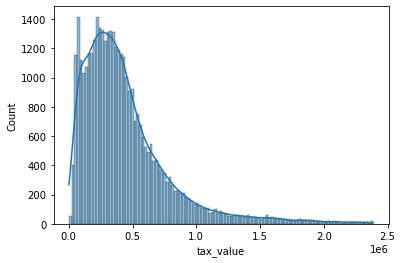

In [37]:
sns.histplot(df.tax_value, kde=True)

In [38]:
df.shape, \
df.tax_value.describe()

((38015, 16),
 count    3.801500e+04
 mean     4.440843e+05
 std      3.583254e+05
 min      1.000000e+03
 25%      2.067060e+05
 50%      3.586800e+05
 75%      5.634630e+05
 max      2.387340e+06
 Name: tax_value, dtype: float64)

### Final column drop

In [39]:
df.drop(columns=['full_bath', 'fireplaceflag'], inplace=True)

## Calculate and add tax_rate to df

In [40]:
df['tax_rate'] = df.taxamount / df.tax_value

df.tax_rate.describe()

Now we work with each county:
#### FIPS codes:
|Fips code| County|
|---|---|
|6037 | Los Angeles County|
|6059 | Orange County|
|6111 | Ventura County|

In [42]:
LA_county = df[df.fips==6037].tax_rate
OC_county = df[df.fips==6059].tax_rate
Ventura_county = df[df.fips==6111].tax_rate

### Create categorical and quantitative vars and target var

In [43]:
cats = ['fips']
quants = ['bath', 'bed', 'sqft', 'garagecarcnt', 'lot_sqft', 'rooms', 'three_qtr_bath', 'year', 'tax_rate', 'pool', 'fireplaces']
target = 'tax_value'

### Train, Validate, and Test split

In [44]:
def split_data(df):
    """
    Splits the data into train, validate, and test dataframes each comprised of 72%, 18%, and 10% of the original dataframe, respectively.
    """
    train_validate, test = train_test_split(df, 
                                            test_size=.1, 
                                            random_state=123)
    train, validate = train_test_split(train_validate, 
                                        test_size=.2, 
                                        random_state=123)
    return train, validate, test

In [45]:
train, validate, test = split_data(df)

In [46]:
train.shape, validate.shape, test.shape

((27370, 15), (6843, 15), (3802, 15))

In [47]:
# Setup X and y
X_train = train.drop(columns='tax_value')
y_train = train.tax_value

X_validate = validate.drop(columns='tax_value')
y_validate = validate.tax_value

X_test = test.drop(columns='tax_value')
y_test = test.tax_value

In [48]:
X_train.shape, y_train.shape, \
X_validate.shape, y_validate.shape, \
X_test.shape, y_test.shape

((27370, 14), (27370,), (6843, 14), (6843,), (3802, 14), (3802,))

### Scale Data

In [49]:
def minmax_scaler(X_train, X_validate, X_test, quants):
    """
    Takes in split data and individually scales each features to a value within the range of 0 and 1.
    Uses min-max scaler method from sklearn.
    Returns datasets with new, scaled columns to the added.
    """
    # Scale the data
    scaler = sklearn.preprocessing.MinMaxScaler()

    # Fit the scaler
    scaler.fit(X_train[quants])

    # Use the scaler to transform train, validate, test
    X_train_scaled = scaler.transform(X_train[quants])
    X_validate_scaled = scaler.transform(X_validate[quants])
    X_test_scaled = scaler.transform(X_test[quants])


    # Turn everything into a dataframe
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train[quants].columns)
    X_validate_scaled = pd.DataFrame(X_validate_scaled, columns=X_train[quants].columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train[quants].columns)
    
    return X_train_scaled, X_validate_scaled, X_test_scaled

In [50]:
X_train_scaled, X_validate_scaled, X_test_scaled = minmax_scaler(X_train, X_validate, X_test, quants)

X_train_scaled.shape, X_validate_scaled.shape, X_test_scaled.shape

In [52]:
X_train.head()

,bath,bed,sqft,fips,fireplaces,garagecarcnt,lot_sqft,pool,rooms,three_qtr_bath,year,taxamount,logerror,tax_rate
36632,2.5,3,1790.0,6059,0,1,3520.0,0,0,1,1997,8945.46,0.092716,0.015318
25964,2.5,3,1943.0,6059,1,2,5500.0,1,7,1,1969,7172.10,0.034180,0.011138
30751,2.0,3,1687.0,6037,0,0,5972.0,0,0,0,1959,4097.23,0.137172,0.013215
24579,2.0,4,2194.0,6059,0,2,10444.0,0,7,0,1957,7076.08,0.046305,0.011342
27491,2.5,4,2309.0,6059,0,2,4737.0,0,0,1,1997,10032.12,-0.018775,0.014138


In [53]:
X_train_scaled.head()

,bath,bed,sqft,garagecarcnt,lot_sqft,rooms,three_qtr_bath,year,tax_rate,pool,fireplaces
0,0.3125,0.272727,0.192594,0.071429,0.000471,0.000000,0.333333,0.862319,0.018590,0.0,0.00
1,0.3125,0.272727,0.211605,0.142857,0.000755,0.538462,0.333333,0.659420,0.013470,1.0,0.25
2,0.2500,0.272727,0.179796,0.000000,0.000823,0.000000,0.000000,0.586957,0.016014,0.0,0.00
3,0.2500,0.363636,0.242793,0.142857,0.001464,0.538462,0.000000,0.572464,0.013720,0.0,0.00
4,0.3125,0.363636,0.257083,0.142857,0.000646,0.000000,0.333333,0.862319,0.017145,0.0,0.00


In [54]:
def explore_univariate(train, cat_vars, quant_vars):
    for var in cat_vars:
        explore_univariate_categorical(train, var)
        print('_________________________________________________________________')
    for col in quant_vars:
        p, descriptive_stats = explore_univariate_quant(train, col)
        plt.show(p)
        print(descriptive_stats)

def explore_bivariate(train, target, cat_vars, quant_vars):
    for cat in cat_vars:
        explore_bivariate_categorical(train, target, cat)
    for quant in quant_vars:
        explore_bivariate_quant(train, target, quant)

def explore_multivariate(train, target, cat_vars, quant_vars):
    '''
    '''
    plot_swarm_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    violin = plot_violin_grid_with_color(train, target, cat_vars, quant_vars)
    plt.show()
    pair = sns.pairplot(data=train, vars=quant_vars, hue=target)
    plt.show()
    plot_all_continuous_vars(train, target, quant_vars)
    plt.show()    


### Univariate

def explore_univariate_categorical(train, cat_var):
    '''
    takes in a dataframe and a categorical variable and returns
    a frequency table and barplot of the frequencies. 
    '''
    frequency_table = freq_table(train, cat_var)
    plt.figure(figsize=(2,2))
    sns.barplot(x=cat_var, y='Count', data=frequency_table, color='lightseagreen')
    plt.title(cat_var)
    plt.show()
    print(frequency_table)

def explore_univariate_quant(train, quant_var):
    '''
    takes in a dataframe and a quantitative variable and returns
    descriptive stats table, histogram, and boxplot of the distributions. 
    '''
    descriptive_stats = train[quant_var].describe()
    plt.figure(figsize=(8,2))

    p = plt.subplot(1, 2, 1)
    p = plt.hist(train[quant_var], color='lightseagreen')
    p = plt.title(quant_var)

    # second plot: box plot
    p = plt.subplot(1, 2, 2)
    p = plt.boxplot(train[quant_var])
    p = plt.title(quant_var)
    return p, descriptive_stats

def freq_table(train, cat_var):
    '''
    for a given categorical variable, compute the frequency count and percent split
    and return a dataframe of those values along with the different classes. 
    '''
    class_labels = list(train[cat_var].unique())

    frequency_table = (
        pd.DataFrame({cat_var: class_labels,
                      'Count': train[cat_var].value_counts(normalize=False), 
                      'Percent': round(train[cat_var].value_counts(normalize=True)*100,2)}
                    )
    )
    return frequency_table


#### Bivariate

def explore_bivariate_categorical(train, target, cat_var):
    '''
    takes in categorical variable and binary target variable, 
    returns a crosstab of frequencies
    runs a chi-square test for the proportions
    and creates a barplot, adding a horizontal line of the overall rate of the target. 
    '''
    print(cat_var, "\n_____________________\n")
    ct = pd.crosstab(train[cat_var], train[target], margins=True)
    chi2_summary, observed, expected = run_chi2(train, cat_var, target)
    p = plot_cat_by_target(train, target, cat_var)

    print(chi2_summary)
    print("\nobserved:\n", ct)
    print("\nexpected:\n", expected)
    plt.show(p)
    print("\n_____________________\n")

def explore_bivariate_quant(train, target, quant_var):
    '''
    descriptive stats by each target class. 
    compare means across 2 target groups 
    boxenplot of target x quant
    swarmplot of target x quant
    '''
    print(quant_var, "\n____________________\n")
    descriptive_stats = train.groupby(target)[quant_var].describe()
    average = train[quant_var].mean()
    mann_whitney = compare_means(train, target, quant_var)
    plt.figure(figsize=(4,4))
    boxen = plot_boxen(train, target, quant_var)
    swarm = plot_swarm(train, target, quant_var)
    plt.show()
    print(descriptive_stats, "\n")
    print("\nMann-Whitney Test:\n", mann_whitney)
    print("\n____________________\n")
    
## Bivariate Categorical

def run_chi2(train, cat_var, target):
    observed = pd.crosstab(train[cat_var], train[target])
    chi2, p, degf, expected = stats.chi2_contingency(observed)
    chi2_summary = pd.DataFrame({'chi2': [chi2], 'p-value': [p], 
                                 'degrees of freedom': [degf]})
    expected = pd.DataFrame(expected)
    return chi2_summary, observed, expected

def plot_cat_by_target(train, target, cat_var):
    p = plt.figure(figsize=(2,2))
    p = sns.barplot(cat_var, target, data=train, alpha=.8, color='lightseagreen')
    overall_rate = train[target].mean()
    p = plt.axhline(overall_rate, ls='--', color='gray')
    return p


## Bivariate Quant

def plot_swarm(train, target, quant_var):
    average = train[quant_var].mean()
    p = sns.swarmplot(data=train, x=target, y=quant_var, color='lightgray')
    p = plt.title(quant_var)
    p = plt.axhline(average, ls='--', color='black')
    return p

def plot_boxen(train, target, quant_var):
    average = train[quant_var].mean()
    p = sns.boxenplot(data=train, x=target, y=quant_var, color='lightseagreen')
    p = plt.title(quant_var)
    p = plt.axhline(average, ls='--', color='black')
    return p

# alt_hyp = ‘two-sided’, ‘less’, ‘greater’

def compare_means(train, target, quant_var, alt_hyp='two-sided'):
    x = train[train[target]==0][quant_var]
    y = train[train[target]==1][quant_var]
    return stats.mannwhitneyu(x, y, use_continuity=True, alternative=alt_hyp)


### Multivariate

def plot_all_continuous_vars(train, target, quant_vars):
    '''
    Melt the dataset to "long-form" representation
    boxenplot of measurement x value with color representing the target variable. 
    '''
    my_vars = [item for sublist in [quant_vars, [target]] for item in sublist]
    sns.set(style="whitegrid", palette="muted")
    melt = train[my_vars].melt(id_vars=target, var_name="measurement")
    plt.figure(figsize=(8,6))
    p = sns.boxenplot(x="measurement", y="value", hue=target, data=melt)
    p.set(yscale="log", xlabel='')    
    plt.show()

def plot_violin_grid_with_color(train, target, cat_vars, quant_vars):
    cols = len(cat_vars)
    for quant in quant_vars:
        _, ax = plt.subplots(nrows=1, ncols=cols, figsize=(16, 4), sharey=True)
        for i, cat in enumerate(cat_vars):
            sns.violinplot(x=cat, y=quant, data=train, split=True, 
                           ax=ax[i], hue=target, palette="Set2")
            ax[i].set_xlabel('')
            ax[i].set_ylabel(quant)
            ax[i].set_title(cat)
        plt.show()

def plot_swarm_grid_with_color(train, target, cat_vars, quant_vars):
    cols = len(cat_vars)
    for quant in quant_vars:
        _, ax = plt.subplots(nrows=1, ncols=cols, figsize=(16, 4), sharey=True)
        for i, cat in enumerate(cat_vars):
            sns.swarmplot(x=cat, y=quant, data=train, ax=ax[i], hue=target, palette="Set2")
            ax[i].set_xlabel('')
            ax[i].set_ylabel(quant)
            ax[i].set_title(cat)
        plt.show()
        
def plot_categorical_and_continuous_vars(train, cats, quants):
    """
    Function takes in a df, categorical variables, and quantitative variable and returns a violin plot, 
    ked plot, and box plot for each combination of categorical vars to quantitative vars.
    """
    for quant in train[quants]:
        print('-------------------------------------------------')
        print(f'{quant}')
        print('-------------------------------------------------')
        for cat in train[cats]:
            print(f'vs. {cat}')    
            fig = plt.figure(figsize=(20,4))

            #subplot 1
            plt.subplot(131)
            plt.title('Violin Plot')
            sns.violinplot(x=quant, y=cat, data=train, palette="Set2")

            #subplot 2
            plt.subplot(132)
            plt.title('Kernel Density Estimate Plot')
            sns.kdeplot(data=train, x=quant, hue=cat, multiple="stack", shade_lowest=True, palette="Set2")

            #subplot 3
            plt.subplot('133')
            sns.boxenplot(data=train, x=quant, y=cat, palette="Set2")
            plt.title('Box Plot')
            print('---------------')
            plt.show() 

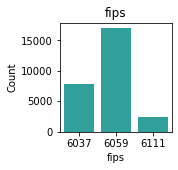

      fips  Count  Percent
6037  6059  17003    62.12
6059  6037   7907    28.89
6111  6111   2460     8.99
_________________________________________________________________


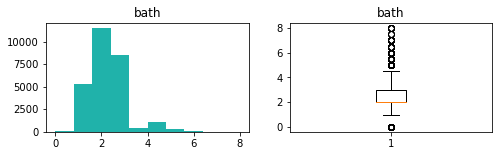

count    27370.000000
mean         2.238199
std          0.882576
min          0.000000
25%          2.000000
50%          2.000000
75%          3.000000
max          8.000000
Name: bath, dtype: float64


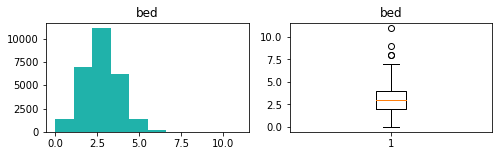

count    27370.000000
mean         2.994483
std          1.005087
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         11.000000
Name: bed, dtype: float64


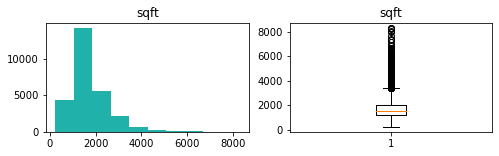

count    27370.000000
mean      1717.955979
std        813.022335
min        240.000000
25%       1168.000000
50%       1516.000000
75%       2047.000000
max       8288.000000
Name: sqft, dtype: float64


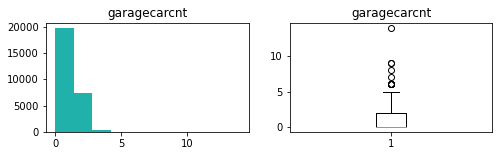

count    27370.000000
mean         0.658677
std          0.936888
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max         14.000000
Name: garagecarcnt, dtype: float64


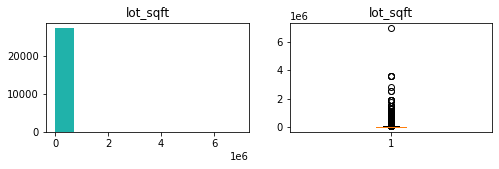

count    2.737000e+04
mean     3.003672e+04
std      1.081476e+05
min      2.360000e+02
25%      6.000000e+03
50%      7.699500e+03
75%      2.325925e+04
max      6.971010e+06
Name: lot_sqft, dtype: float64


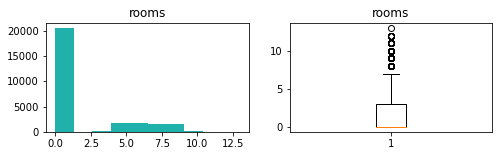

count    27370.000000
mean         1.637998
std          2.931541
min          0.000000
25%          0.000000
50%          0.000000
75%          3.000000
max         13.000000
Name: rooms, dtype: float64


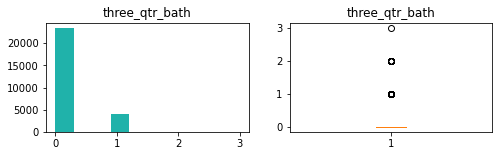

count    27370.000000
mean         0.146328
std          0.356016
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: three_qtr_bath, dtype: float64


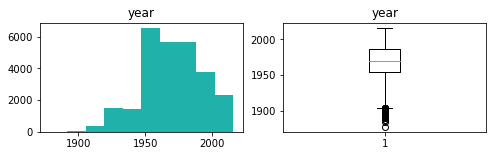

count    27370.000000
mean      1969.393350
std         22.870767
min       1878.000000
25%       1954.000000
50%       1970.000000
75%       1987.000000
max       2016.000000
Name: year, dtype: float64


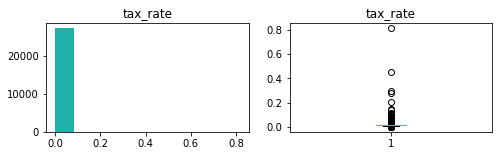

count    27370.000000
mean         0.013138
std          0.007217
min          0.000141
25%          0.011584
50%          0.012246
75%          0.013384
max          0.816490
Name: tax_rate, dtype: float64


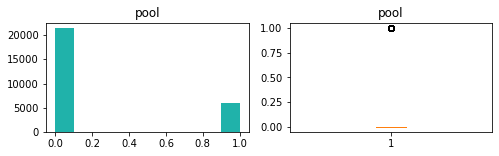

count    27370.000000
mean         0.216478
std          0.411851
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: pool, dtype: float64


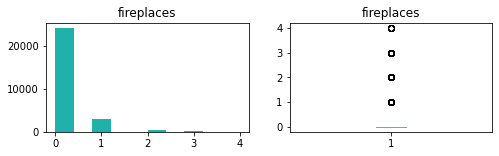

count    27370.000000
mean         0.144282
std          0.416915
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: fireplaces, dtype: float64


In [55]:
def explore_univariate(train, cat_vars, quant_vars):
    for var in cat_vars:
        explore_univariate_categorical(train, var)
        print('_________________________________________________________________')
    for col in quant_vars:
        p, descriptive_stats = explore_univariate_quant(train, col)
        plt.show(p)
        print(descriptive_stats)
explore_univariate(train, cats, quants)

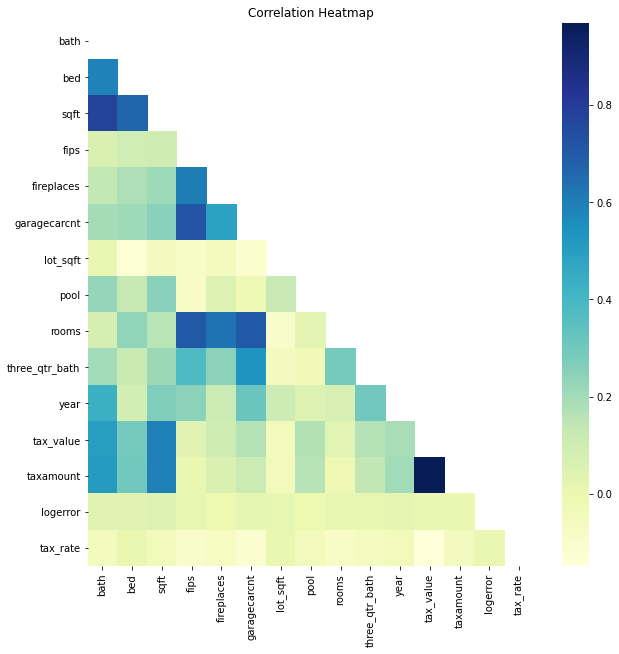

In [104]:
def get_hot(df):
    plt.figure(figsize=(10,10))
    mask = df.corr()
    sns.heatmap(mask, cmap="YlGnBu", mask=np.triu(mask))
    plt.title('Correlation Heatmap')
get_hot(train)

**Takeaways**
- bed, bath, sqft appear to be have sever collinearity (data collinearity)
- fireplaces, garagecarcnt, fips appear to be have sever collinearity (data collinearity)
- bed, bath, sqft also appear to be the strongest predictor of `tax_value`
    > year, pool, and garagecarcnt are the next most correlated

# Explore

## Initial Hypotheses
Let's makes some hypothesis!!!
### Hypothesis 1:

#### Set Hypothesis

$H_{0}$: Mean tax_value of lot_sqft in top 25% <= Mean tax_value of lot_sqft in bottom 25% 

$H_{a}$: Mean tax_value of lot_sqft in top 25% > Mean tax_value of lot_sqft in bottom 25% 

#### Visualize

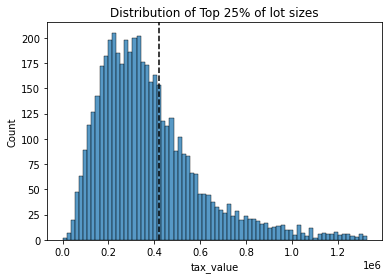

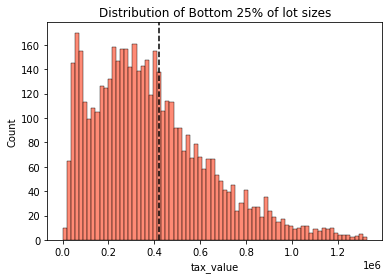

In [57]:
top_lot_tax_value = train[train.lot_sqft > train.lot_sqft.quantile(.75)].tax_value
top_mean = top_lot_tax_value.mean()
bot_lot_tax_value = train[train.lot_sqft < train.lot_sqft.quantile(.25)].tax_value
bot_mean = bot_lot_tax_value.mean()

bins=[]
for i in np.arange(0,3.75, 0.05):
    bins.append(i*round(df.tax_value.std(), 2))
    
plt.title('Distribution of Top 25% of lot sizes')
sns.histplot(top_lot_tax_value.head(5000), bins=bins)
plt.axvline(top_mean, color='black', linestyle='--')
plt.show()

plt.title('Distribution of Bottom 25% of lot sizes')
sns.histplot(bot_lot_tax_value.head(5000), bins=bins, color='tomato')
plt.axvline(bot_mean, color='black', linestyle='--')
plt.show()

#### Set Alpha

$\alpha$ = 0.5

In [58]:
a = 0.05

**T-test: 2-Sample**

In [59]:
t, p = stats.ttest_ind(top_lot_tax_value, bot_lot_tax_value, equal_var = False)
t, p/2

(0.02499573468595714, 0.4900293667556765)

In [60]:
print("is p/2 < alpha? ", p/2 < a)
print("is t > 0? ", t > 0)
if p/2 > a:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

is p/2 < alpha?  False
is t > 0?  True
We fail to reject $H_{0}$


Therefore, on average, lot sizes in the bottom 25% of total area have property values greater than or equal to lots that are in the top 25%.
___

Bedroom count is correlated with tax value
### Hypothesis 2:

#### Set Hypothesis

$H_{0}$: There is no linear correlation between year built and tax value.

$H_{a}$: There is a linear correlation between year built and tax value.

#### Visualize

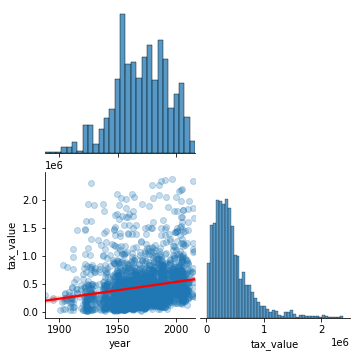

In [61]:
sns.pairplot(train[['year','tax_value']].sample(2_500), kind="reg", plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': .25}}, corner=True)

#### Set Alpha

$\alpha$ = 0.5

In [62]:
a = 0.05

**Correlation Test: Pearsonr**

In [63]:
corr, p = stats.pearsonr(X_train.year, y_train)
corr, p

(0.18853256689816394, 2.112833150027512e-217)

In [64]:
print("is p < alpha? ", p < a)
if p < a:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

is p < alpha?  True
We fail to reject $H_{0}$


Therefore, the year a property is built is not linearly correlated with tax value.

___

### Hypothesis 3:

#### Set Hypothesis

$H_{0}$: Mean tax value of houses with at least fireplace == Mean tax value of houses without a fireplace

$H_{a}$: Mean tax value of houses with at least fireplace != Mean tax value of houses without a fireplace 

#### Visualize

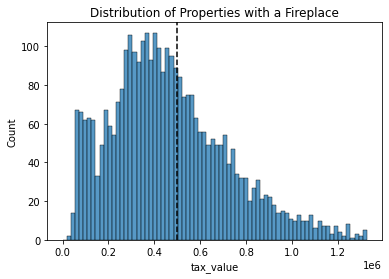

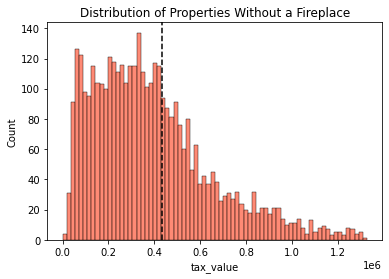

In [65]:
fire_tax_value = train[train.fireplaces > 0].tax_value
fire_mean = fire_tax_value.mean()
no_fire_tax_value = train[train.fireplaces == 0].tax_value
no_fire = no_fire_tax_value.mean()

bins=[]
for i in np.arange(0,3.75, 0.05):
    bins.append(i*round(df.tax_value.std(), 2))
    
plt.title('Distribution of Properties with a Fireplace')
sns.histplot(fire_tax_value.head(4_000), bins=bins)
plt.axvline(fire_mean, color='black', linestyle='--')
plt.show()

plt.title('Distribution of Properties Without a Fireplace')
sns.histplot(no_fire_tax_value.head(4_000), bins=bins, color='tomato')
plt.axvline(no_fire, color='black', linestyle='--')
plt.show()

#### Set Alpha

$\alpha$ = 0.5

In [66]:
a = 0.05

**T-test: 2-Sample**

In [67]:
t, p = stats.ttest_ind(fire_tax_value, no_fire_tax_value, equal_var = False)
t, p/2

(10.27283106824668, 8.546502433924064e-25)

In [68]:
print("is p/2 < alpha? ", p/2 < a)
print("is t > 0? ", t > 0)
if p/2 > a:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

is p/2 < alpha?  True
is t > 0?  True
We reject $H_{0}$


Therefore, on average, fireplaces increase the tax value of a property.

___

### Hypothesis 4:

#### Set Hypothesis

$H_{0}$: Mean tax value of houses with pools == Mean tax value of houses without pools

$H_{a}$: Mean tax value of houses with pools != Mean tax value of houses without pools 

#### Visualize

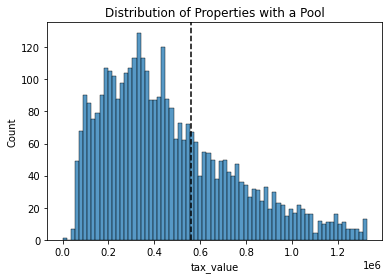

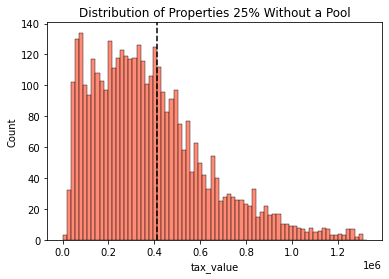

In [69]:
pool_tax_value = train[train.pool == 1].tax_value
pool_mean = pool_tax_value.mean()
no_pool_tax_value = train[train.pool == 0].tax_value
no_pool = no_pool_tax_value.mean()

bins=[]
for i in np.arange(0,3.75, 0.05):
    bins.append(i*round(df.tax_value.std(), 2))
    
plt.title('Distribution of Properties with a Pool')
sns.histplot(pool_tax_value.head(4_000), bins=bins)
plt.axvline(pool_mean, color='black', linestyle='--')
plt.show()

plt.title('Distribution of Properties 25% Without a Pool')
sns.histplot(no_pool_tax_value.head(4_000), bins=bins, color='tomato')
plt.axvline(no_pool, color='black', linestyle='--')
plt.show()

#### Set Alpha

$\alpha$ = 0.5

In [70]:
a = 0.05

**T-test: 2-Sample**

In [71]:
t, p = stats.ttest_ind(pool_tax_value, no_pool_tax_value, equal_var = False)
t, p/2

(24.41523404153557, 3.0486009773326137e-127)

In [72]:
print("is p/2 < alpha? ", p/2 < a)
print("is t > 0? ", t > 0)
if p/2 > a:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

is p/2 < alpha?  True
is t > 0?  True
We reject $H_{0}$


Therefore, on average, pools increase the tax value of a property.

**Takeaways**

## Modeling

In [73]:
#turning my y_train and y_validate to dataframes so we can append new columns
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#tax_value mean
mean_baseline = y_train['tax_value'].mean()
y_train['mean_baseline'] = mean_baseline
y_validate['mean_baseline'] = mean_baseline

#RMSE of tax_value_pred_mean
rmse_train_mean = mean_squared_error(y_train.tax_value, y_train.mean_baseline)**(1/2)
rmse_validate_mean = mean_squared_error(y_validate.tax_value, y_validate.mean_baseline)**(1/2)

#R^2 Score of mean
r2_baseline_mean = r2_score(y_validate.tax_value, y_validate.mean_baseline)

print('             BASELINE')
print('----------------------------------')
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train_mean, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_mean, 2))
print('r^2 Score:')
print(f'Mean: {r2_baseline_mean}')
print('----------------------------------')

#tax_value_median
median_baseline = y_train['tax_value'].median()
y_train['median_baseline'] = median_baseline
y_validate['median_baseline'] = median_baseline

#RMSE of tax_value_pred_median
rmse_train_median = mean_squared_error(y_train.tax_value, y_train.median_baseline)**(1/2)
rmse_validate_median = mean_squared_error(y_validate.tax_value, y_validate.median_baseline)**(1/2)

#R^2 Score of median
r2_baseline_median = r2_score(y_validate.tax_value, y_validate.median_baseline)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train_median, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate_median, 2))
print(f'Median: {r2_baseline_median}')
print('r^2 Score:')
print(f'Median: {r2_baseline_median}')
print('----------------------------------')

             BASELINE
----------------------------------
RMSE using Mean
Train/In-Sample:  358420.6 
Validate/Out-of-Sample:  359255.2
r^2 Score:
Mean: -0.0006325936482305394
----------------------------------
RMSE using Median
Train/In-Sample:  368494.31 
Validate/Out-of-Sample:  371393.29
Median: -0.06939124388405937
r^2 Score:
Median: -0.06939124388405937
----------------------------------


#### Mean will be our baseline!

In [74]:
y_train.drop(columns='median_baseline', inplace=True)

In [75]:
def baseline_mean_errors(df, y):
    baseline = df[y].mean()
    base_res = df[y] - baseline
    base_res_sq = base_res**2
    SSE_baseline = base_res_sq.sum()
    MSE_baseline = SSE_baseline/len(df[y])
    RMSE_baseline = MSE_baseline**0.5
    return SSE_baseline, MSE_baseline, RMSE_baseline
SSE_baseline, MSE_baseline, RMSE_baseline = baseline_mean_errors(y_train, 'tax_value')
SSE_baseline, MSE_baseline, RMSE_baseline

(3516096008911716.5, 128465327325.967, 358420.6011461492)

In [76]:
def regression_errors(df, y, yhat):
    residual = df[yhat] - df[y]
    residual_sq = residual**2
    SSE = residual_sq.sum()
    ESS = ((df[yhat] - df[y].mean())**2).sum()
    TSS = SSE + ESS
    MSE = SSE/len(df[y])
    RMSE = MSE**0.5
    return SSE, ESS, TSS, MSE, RMSE
SSE_baseline, ESS_baseline, TSS_baseline, MSE_baseline, RMSE_baseline = regression_errors(y_train, 'tax_value', 'mean_baseline')

In [77]:
#df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])
df_baseline_eval = pd.DataFrame(np.array(['SSE_baseline','MSE_baseline','RMSE_baseline']), columns=['metric'])

#df_eval['model_error'] = np.array([SSE, MSE, RMSE])
df_baseline_eval['baseline_error'] = np.array([SSE_baseline, MSE_baseline, RMSE_baseline])

df_baseline_eval

,metric,baseline_error
0,SSE_baseline,3.516096e+15
1,MSE_baseline,1.284653e+11
2,RMSE_baseline,3.584206e+05


In [78]:
# kbest:
kbest = SelectKBest(f_regression, k=8)
kbest.fit(X_train_scaled.drop(columns=['tax_rate']), y_train.tax_value)
X_kbest = X_train_scaled.drop(columns=['tax_rate']).columns[kbest.get_support()]

# recursive feature elimination:
rfe = RFE(estimator=LinearRegression(), n_features_to_select=8)
rfe.fit(X_train_scaled.drop(columns=['tax_rate']), y_train)
X_rfe = X_train_scaled.drop(columns=['tax_rate']).columns[rfe.get_support()]

In [79]:
X_kbest, X_rfe

(Index(['bath', 'bed', 'sqft', 'garagecarcnt', 'three_qtr_bath', 'year', 'pool',
        'fireplaces'],
       dtype='object'),
 Index(['bath', 'bed', 'sqft', 'garagecarcnt', 'lot_sqft', 'rooms',
        'three_qtr_bath', 'year'],
       dtype='object'))

Since i saw that lot_sqft is not a good predictor of tax_value, i will use the kbest columns

### OLS Regression

In [80]:
# create the model
ols = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
ols.fit(X_train_scaled[X_kbest], y_train['tax_value'])

# predict train
y_train['ols_yhat'] = ols.predict(X_train_scaled[X_kbest])

# evaluate: rmse
rmse_train = mean_squared_error(y_train['tax_value'], y_train['ols_yhat'])**(1/2)

# predict validate
y_validate['ols_yhat'] = ols.predict(X_validate_scaled[X_kbest])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate['tax_value'], y_validate['ols_yhat'])**(1/2)

print("RMSE for OLS\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS
Training/In-Sample:  280536.9562497502 
Validation/Out-of-Sample:  281631.7498382987


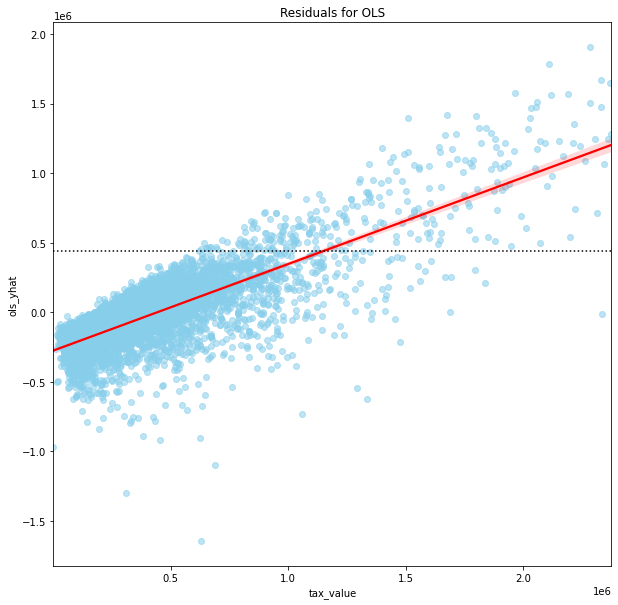

In [81]:
def plot_residuals(df, y, yhat, model_name):
    plt.figure(figsize=(10,10))
    plt.title(f'Residuals for {model_name}')
    sns.regplot(data=df, x=y, y=df[y]-df[yhat], scatter_kws={'color':'skyblue','alpha': .55}, line_kws={'color':'red'})
    plt.axhline(df[yhat].mean(), ls = ':', color='black')
    plt.ylabel(yhat)
    plt.show()
plot_residuals(y_train.head(5_000), 'tax_value', 'ols_yhat', 'OLS')

In [82]:
def regression_errors(df, y, yhat):
    residual = df[yhat] - df[y]
    residual_sq = residual**2
    SSE = residual_sq.sum()
    ESS = ((df[yhat] - df[y].mean())**2).sum()
    TSS = SSE + ESS
    MSE = SSE/len(df[y])
    RMSE = MSE**0.5
    return SSE, ESS, TSS, MSE, RMSE
SSE, ESS, TSS, MSE, RMSE = regression_errors(y_train, 'tax_value', 'ols_yhat')

In [83]:
def better_than_baseline(df, y, yhat):
    SSE_baseline, MSE_baseline, RMSE_baseline = baseline_mean_errors(df, y)
    SSE, ESS, TSS, MSE, RMSE = regression_errors(df, y, yhat)
    return RMSE < RMSE_baseline
better_than_baseline(y_train, 'tax_value', 'ols_yhat')

True

In [84]:
df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])

df_eval['model_error'] = np.array([SSE, MSE, RMSE])

df_eval['delta_error'] = df_eval.model_error - df_baseline_eval.baseline_error
df_eval['model>baseline'] = better_than_baseline(y_train, 'tax_value', 'ols_yhat')
df_eval

,metric,model_error,delta_error,model>baseline
0,SSE,2.154046e+15,-1.362050e+15,True
1,MSE,7.870098e+10,-4.976434e+10,True
2,RMSE,2.805370e+05,-7.788364e+04,True


In [85]:
# Explained Variance
ols_r2 = r2_score(y_train.tax_value, y_train.ols_yhat)
ols_r2

0.3873756798036333

### LassoLars Regression

In [86]:
# create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train_scaled[X_kbest], y_train['tax_value'])

# predict train
y_train['lars_yhat'] = lars.predict(X_train_scaled[X_kbest])

# evaluate: rmse
rmse_train = mean_squared_error(y_train['tax_value'], y_train['lars_yhat'])**(1/2)

# predict validate
y_validate['lars_yhat'] = lars.predict(X_validate_scaled[X_kbest])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate['tax_value'], y_validate['lars_yhat'])**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  280537.805393434 
Validation/Out-of-Sample:  281631.0766703087


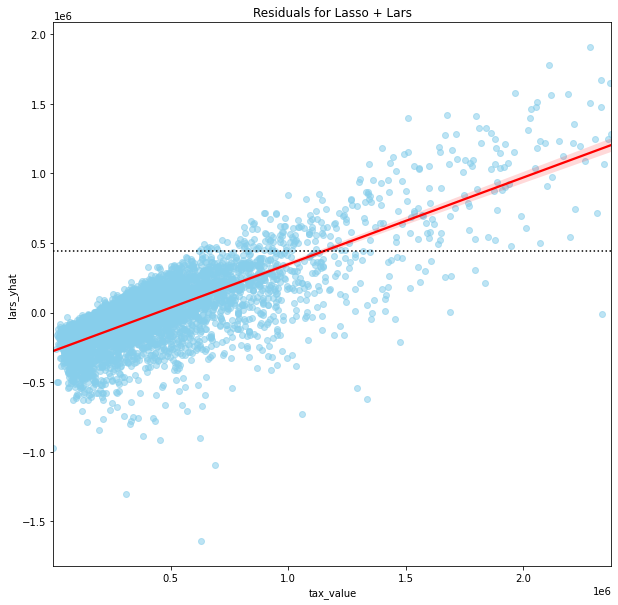

In [87]:
plot_residuals(y_train.head(5_000), 'tax_value', 'lars_yhat', 'Lasso + Lars')

In [88]:
SSE, ESS, TSS, MSE, RMSE = regression_errors(y_train, 'tax_value', 'lars_yhat')
df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])

df_eval['model_error'] = np.array([SSE, MSE, RMSE])

df_eval['delta_error'] = df_eval.model_error - df_baseline_eval.baseline_error
df_eval['model>baseline'] = better_than_baseline(y_train, 'tax_value', 'lars_yhat')
df_eval

,metric,model_error,delta_error,model>baseline
0,SSE,2.154059e+15,-1.362037e+15,True
1,MSE,7.870146e+10,-4.976387e+10,True
2,RMSE,2.805378e+05,-7.788280e+04,True


In [89]:
# Explained Variance
lars_r2 = r2_score(y_train.tax_value, y_train.lars_yhat)
lars_r2

0.38737197115243593

### TweedieRegressor (GLM) Regression

In [90]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0.5)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train_scaled[X_kbest], y_train['tax_value'])

# predict train
y_train['glm_yhat'] = glm.predict(X_train_scaled[X_kbest])

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.glm_yhat)**(1/2)

# predict validate
y_validate['glm_yhat'] = glm.predict(X_validate_scaled[X_kbest])

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.glm_yhat)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=1\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=1
Training/In-Sample:  299522.94365084416 
Validation/Out-of-Sample:  325191.3965728223


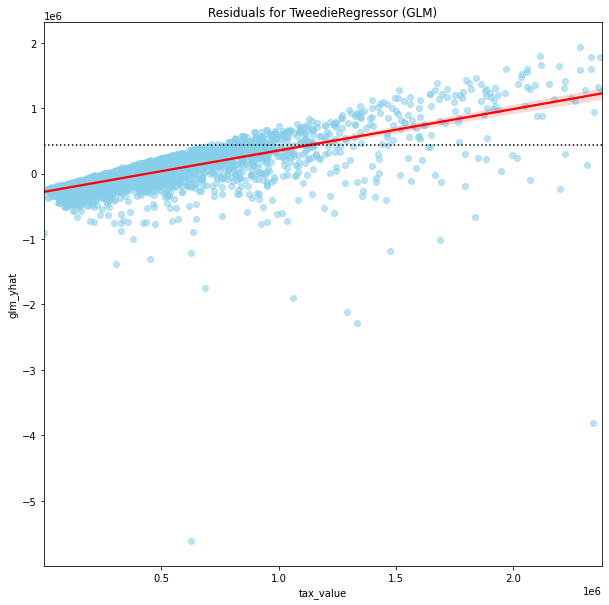

In [91]:
plot_residuals(y_train.head(5_000), 'tax_value', 'glm_yhat', 'TweedieRegressor (GLM)')

In [92]:
SSE, ESS, TSS, MSE, RMSE = regression_errors(y_train, 'tax_value', 'glm_yhat')
df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE']), columns=['metric'])

df_eval['model_error'] = np.array([SSE, MSE, RMSE])

df_eval['delta_error'] = df_eval.model_error - df_baseline_eval.baseline_error
df_eval['model>baseline'] = better_than_baseline(y_train, 'tax_value', 'glm_yhat')
df_eval

,metric,model_error,delta_error,model>baseline
0,SSE,2.455472e+15,-1.060624e+15,True
1,MSE,8.971399e+10,-3.875133e+10,True
2,RMSE,2.995229e+05,-5.889766e+04,True


In [93]:
# Explained Variance
glm_r2 = r2_score(y_train.tax_value, y_train.glm_yhat)
glm_r2

0.30164819067772963

### Polynomial

In [94]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train_scaled[X_kbest])

# transform X_validate_scaled
X_validate_degree3 = pf.transform(X_validate_scaled[X_kbest])

# create the model object
lm3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm3.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['lm3_yhat'] = lm3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.lm3_yhat)**(1/2)

# predict validate
y_validate['lm3_yhat'] = lm3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.lm3_yhat)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  270195.45882588753 
Validation/Out-of-Sample:  280802.7635480066


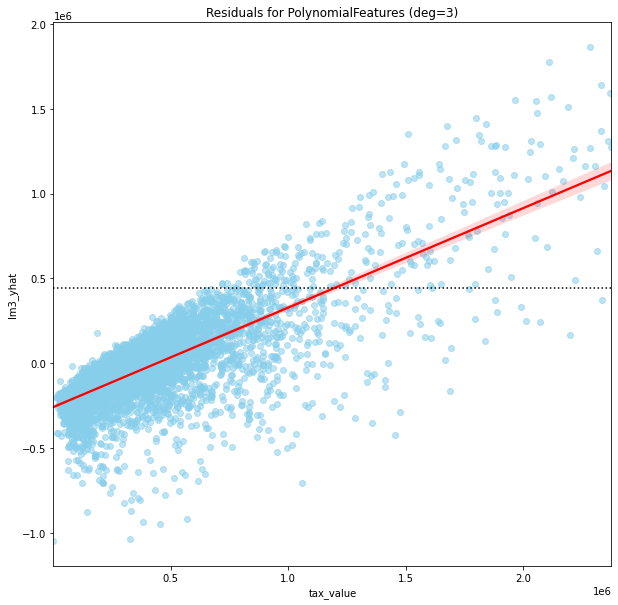

In [95]:
plot_residuals(y_train.head(5_000), 'tax_value', 'lm3_yhat', 'PolynomialFeatures (deg=3)')

In [96]:
SSE, ESS, TSS, MSE, RMSE = regression_errors(y_train, 'tax_value', 'lm3_yhat')
df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE', 'R2']), columns=['metric'])

df_eval['model_error'] = np.array([SSE, MSE, RMSE])

df_eval['delta_error'] = df_eval.model_error - df_baseline_eval.baseline_error
df_eval['model>baseline'] = better_than_baseline(y_train, 'tax_value', 'lm3_yhat')
df_eval

,metric,model_error,delta_error,model>baseline
0,SSE,1.998163e+15,-1.517933e+15,True
1,MSE,7.300559e+10,-5.545974e+10,True
2,RMSE,2.701955e+05,-8.822514e+04,True


In [97]:
# Explained Variance
lm3_r2 = r2_score(y_train.tax_value, y_train.lm3_yhat)
lm3_r2

0.4317098045849519

#### Takeaway

### Test

In [98]:
y_test = pd.DataFrame(y_test)

X_test_degree3 =  pf.fit_transform(X_test_scaled[X_kbest])

lm3.fit(X_test_degree3, y_test.tax_value)

# predict on test
y_test['lm3_yhat'] = lm3.predict(X_test_degree3)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.tax_value, y_test.lm3_yhat) ** (1/2)

print("RMSE for Polynomial Model using LinearRegression\nOut-of-Sample Performance: ", rmse_test)

RMSE for Polynomial Model using LinearRegression
Out-of-Sample Performance:  261727.7561884678


In [99]:
SSE, ESS, TSS, MSE, RMSE = regression_errors(y_test, 'tax_value', 'lm3_yhat')
df_eval = pd.DataFrame(np.array(['SSE','MSE','RMSE', 'R2']), columns=['metric'])

df_eval['model_error'] = np.array([SSE, MSE, RMSE])

df_eval['delta_error'] = df_eval.model_error - df_baseline_eval.baseline_error
df_eval['model>baseline'] = better_than_baseline(y_test, 'tax_value', 'lm3_yhat')
df_eval

,metric,model_error,delta_error,model>baseline
0,SSE,2.604424e+14,-3.255654e+15,True
1,MSE,6.850142e+10,-5.996391e+10,True
2,RMSE,2.617278e+05,-9.669284e+04,True


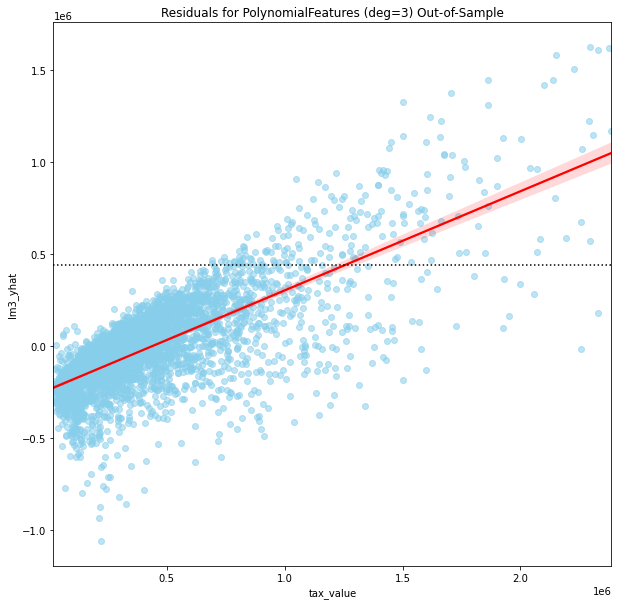

In [100]:
plot_residuals(y_test.head(5_000), 'tax_value', 'lm3_yhat', 'PolynomialFeatures (deg=3) Out-of-Sample')

## Tax Rates per County

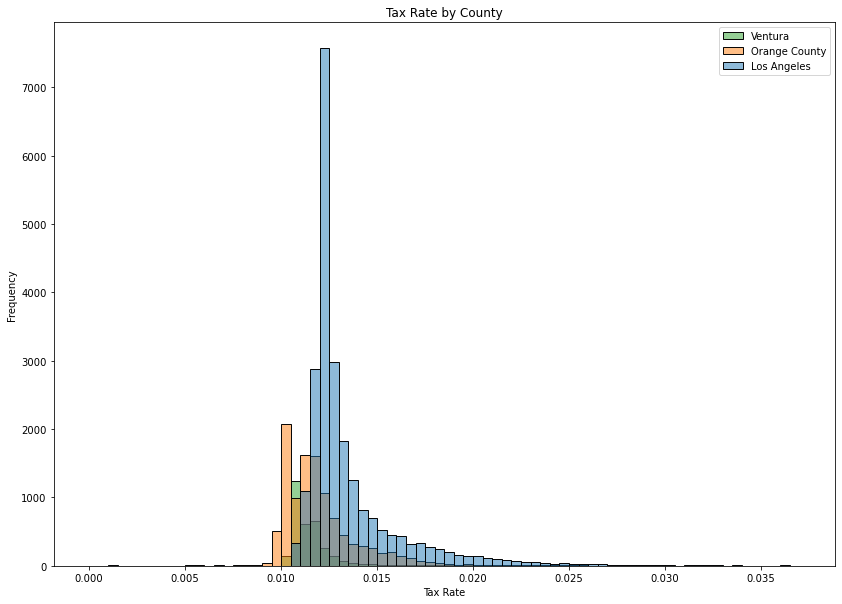

In [101]:
bins=[]
for i in np.arange(0,3.75, 0.05):
    bins.append(i*round(df.tax_rate.std(), 2))

plt.figure(figsize=(14,10))
sns.histplot(data=df, x=df.tax_rate, bins=bins, hue=df.fips, palette='tab10')

plt.title('Tax Rate by County')
plt.xlabel('Tax Rate')
plt.ylabel('Frequency')

# replace legend
plt.legend(['Ventura', 'Orange County', 'Los Angeles'])